Progetto di Big Data In Economics, a cura di:


*   Licciardello Matteo, MAT.799368
*   Mariani Paolo, MAT.800307



In [0]:
!pip install -U skater

## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Librerie

In [0]:
!pip install kaggle
!mkdir .kaggle
!pip install pyGPGO
!pip install ipython-autotime
!pip install lime
%load_ext autotime

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import dill
import seaborn as sns
from collections import Counter
from datetime import datetime

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.utils import class_weight, resample
from sklearn.metrics import make_scorer

# pyGPGO

from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

# Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1,l2,l1_l2
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K

# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# xgboost
from xgboost import XGBClassifier, XGBRegressor

# Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Lime
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

#Classificazione prezzo 70 modelli (con binning)

In [0]:
df = pd.read_csv('/content/drive/My Drive/progetto_bdie/CONSEGNA/clean.csv', index_col=0)

I dataframe utilizzati in questo notebook sono stati prodotti nel notebook precedente 'NB1 - Preprocessing.ipynb'

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140503 entries, 15 to 539758
Data columns (total 15 columns):
region          140503 non-null int64
price           140503 non-null int64
year            140503 non-null int64
manufacturer    140503 non-null int64
model           140503 non-null int64
condition       140503 non-null int64
cylinders       140503 non-null int64
fuel            140503 non-null int64
odometer        140503 non-null int64
title_status    140503 non-null int64
transmission    140503 non-null int64
drive           140503 non-null int64
type            140503 non-null int64
paint_color     140503 non-null int64
state           140503 non-null int64
dtypes: int64(15)
memory usage: 17.2 MB
time: 9.13 ms


Rispetto al dataset originale le operazioni di preprocessing hanno ristretto il dataframe a 140503 elementi

# Preprocessing per i modelli di classificazione e Train-Test Split

In [0]:
label = df.price
df.drop('price', inplace=True, axis=1)

time: 9.42 ms


In [0]:
df = (df - df.min()) / (df.max() - df.min())
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
15,0.199501,0.864407,0.933333,0.136364,0.000000,0.428571,0.5,1.0,0.0,0.0,0.5,0.750000,0.000000,0.10
43,0.807980,0.694915,0.600000,0.560606,0.166667,0.714286,0.5,1.0,0.0,0.0,0.0,0.000000,0.083333,0.62
58,0.324190,0.474576,0.133333,0.803030,0.333333,0.857143,0.5,1.0,0.0,0.0,0.0,0.833333,0.000000,0.54
86,0.807980,0.949153,0.800000,0.000000,0.000000,0.857143,0.5,1.0,0.0,0.0,0.0,0.833333,0.000000,0.62
91,0.698254,0.677966,0.800000,0.045455,0.500000,0.714286,0.0,1.0,0.0,0.0,0.0,0.833333,0.916667,0.28


time: 65.9 ms


In [0]:
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

time: 29.9 ms


# Classificatori

## Random Forest

In [0]:
clf = RandomForestClassifier(n_estimators=100, max_depth=24, random_state=42)
clf.fit(x_train, y_train)
rf_pred = clf.predict(x_test)

time: 15.6 s


In [0]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6631
           1       0.74      0.71      0.72      5003
           2       0.69      0.71      0.70      3376
           3       0.67      0.63      0.65      2005
           4       0.64      0.71      0.68      1692
           5       0.61      0.55      0.58       810
           6       0.65      0.55      0.59       522
           7       0.62      0.50      0.55       201
           8       0.60      0.57      0.58       130
           9       0.76      0.80      0.78      7601
          10       0.68      0.45      0.54        55
          11       0.80      0.44      0.57        27
          12       0.40      0.31      0.35        13
          13       0.76      0.91      0.83        34
          14       0.00      0.00      0.00         1

    accuracy                           0.75     28101
   macro avg       0.63      0.58      0.60     28101
weighted avg       0.75   

### Cross validation

In [0]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
vect = cross_val_score(clf, df, label, cv=kfold)
print("Media: %.3f%%, (+/- %.3f%%)" % (np.mean(vect), np.std(vect)))

Media: 0.752%, (+/- 0.004%)
time: 2min 46s


## XGBoost

In [0]:
xgb = XGBClassifier(max_depth=30, learning_rate=0.1, n_estimators=50, gamma= 0,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=42)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

time: 3min 39s


In [0]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6631
           1       0.72      0.68      0.70      5003
           2       0.67      0.71      0.69      3376
           3       0.64      0.62      0.63      2005
           4       0.63      0.67      0.65      1692
           5       0.59      0.51      0.54       810
           6       0.60      0.49      0.54       522
           7       0.58      0.45      0.51       201
           8       0.55      0.45      0.49       130
           9       0.75      0.80      0.77      7601
          10       0.58      0.38      0.46        55
          11       0.85      0.41      0.55        27
          12       0.00      0.00      0.00        13
          13       0.67      0.88      0.76        34
          14       0.00      0.00      0.00         1

    accuracy                           0.74     28101
   macro avg       0.58      0.53      0.54     28101
weighted avg       0.73   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation

In [0]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
vect = cross_val_score(xgb, df, label, cv=kfold)
print("Media: %.3f%%, (+/- %.3f%%)" % (np.mean(vect), np.std(vect)))

Media: 0.742%, (+/- 0.004%)
time: 38min 35s


## Rete neurale

In [0]:
n_classes = len(np.unique(y_train))
n_features = x_train.shape[1]

time: 5.58 ms


In [0]:
nn = Sequential()

nn.add(Dense(n_features, input_dim =  n_features, activation = "relu"))
nn.add(Dense(1024, activation = "relu"))
nn.add(Dropout(0.3))
nn.add(Dense(512, activation = "relu"))
nn.add(Dropout(0.3))
nn.add(Dense(256, activation = "relu"))
nn.add(Dropout(0.3))
nn.add(Dense(128, activation = "relu"))
nn.add(Dropout(0.3))
nn.add(Dense(n_classes, activation="softmax"))

nn.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              15360     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
__

In [0]:
nn.compile(keras.optimizers.adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=["acc"])



time: 61.8 ms


In [0]:
history = nn.fit(x_train.values, y_train, 
                    batch_size = 512,
                    epochs = 300,
                    #class_weight = class_weights, 
                    validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 89921 samples, validate on 22481 samples
Epoch 1/300





89921/89921 [==============================] - 3s 29us/step - loss: 2.0294 - acc: 0.2582 - val_loss: 1.7172 - val_acc: 0.3462
Epoch 2/300
89921/89921 [==============================] - 1s 16us/step - loss: 1.6949 - acc: 0.3399 - val_loss: 1.5409 - val_acc: 0.4154
Epoch 3/300
89921/89921 [==============================] - 1s 16us/step - loss: 1.5713 - acc: 0.3860 - val_loss: 1.4557 - val_acc: 0.4364
Epoch 4/300
89921/89921 [==============================] - 1s 16us/step - loss: 1.4937 - acc: 0.4108 - val_loss: 1.3887 - val_acc: 0.4593
Epoch 5/300
89921/89921 [==============================] - 1s 16us/step - loss: 1.4398 - acc: 0.4323 - val_loss: 1.3377 - val_acc: 0.4723
Epoch 6/300
89921/89921 [==============================] - 1s 16us/step - loss: 1.3981 - acc: 0.4424 - val_loss: 1.2976 - val_acc: 0.4867
Epoch 7/300
89921/89

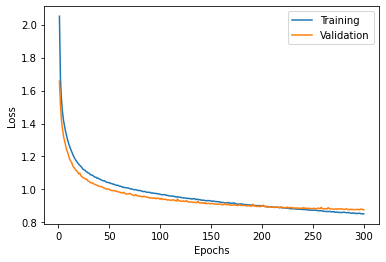

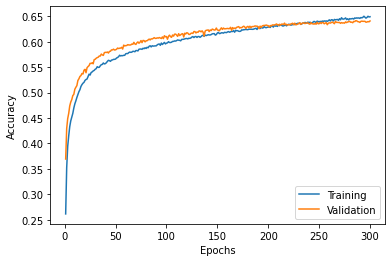

time: 413 ms


In [0]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
plot_history(history)

In [0]:
y_pred = nn.predict_classes(x_test.values)

time: 941 ms


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6631
           1       0.62      0.64      0.63      5003
           2       0.58      0.59      0.58      3376
           3       0.51      0.43      0.46      2005
           4       0.49      0.64      0.55      1692
           5       0.38      0.23      0.29       810
           6       0.41      0.38      0.39       522
           7       0.35      0.18      0.24       201
           8       0.30      0.34      0.32       130
           9       0.70      0.72      0.71      7601
          10       0.24      0.09      0.13        55
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        13
          13       0.53      0.91      0.67        34
          14       0.00      0.00      0.00         1

    accuracy                           0.65     28101
   macro avg       0.39      0.39      0.38     28101
weighted avg       0.64   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross Validation

In [0]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cvscores = []
i = 1
for train, test in kfold.split(df, label): 
  model = Sequential()

  model.add(Dense(n_features, input_dim =  n_features, activation = "relu"))
  model.add(Dense(1024, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes, activation="softmax"))
  
  model.compile(keras.optimizers.adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=["acc"])
	# Fit the model
  model.fit(df.iloc[train], label.iloc[train], 
                    batch_size = 512,
                    epochs = 300,
                    validation_split = 0.2)
	# evaluate the model
  scores = model.evaluate(df.iloc[test], label.iloc[test], verbose=0)
  print(i)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  i +=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Streaming output truncated to the last 5000 lines.
101161/101161 [==============================] - 1s 9us/step - loss: 0.8796 - acc: 0.6382 - val_loss: 0.8673 - val_acc: 0.6417
Epoch 216/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8782 - acc: 0.6389 - val_loss: 0.8687 - val_acc: 0.6405
Epoch 217/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8766 - acc: 0.6397 - val_loss: 0.8679 - val_acc: 0.6426
Epoch 218/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8757 - acc: 0.6398 - val_loss: 0.8689 - val_acc: 0.6412
Epoch 219/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8760 - acc: 0.6404 - val_loss: 0.8695 - val_acc: 0.6401
Epoch 220/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8782 - acc: 0.6389 - val_loss: 0.8663 - val_acc: 0.6420
Epoch 221/300
101161/101161 [==============================] - 1s 9us/step - loss: 0.8748 - acc: 0.6393 - val_loss: 0

# Explainable AI

Si vuole integrare ai risultati una parte di XAI, una tecnica che permette di spiegare quali variabili esplicative risultino più influenti nella classificazione della variabile target.

##Skater

In [0]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [0]:
df2 = pd.concat([df, label], axis = 1)
df2.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'price'],
      dtype='object')

time: 14.8 ms


###Sampling del dataset per raggiungere 15000 osservazioni (massimo consentito dalla libreria skater)

In [0]:
df2.shape

(140503, 15)

time: 2.88 ms


In [0]:
df2 = resample(df2, n_samples = 15000, random_state = 42, replace = False, stratify = df2)

time: 5.35 s


In [0]:
df2.shape

(15000, 15)

time: 3.42 ms


In [0]:
label2 = df2.price
df2.drop("price", axis = 1, inplace=True)
x_train2, x_test2, y_train2, y_test2 = train_test_split(df2, label2, random_state = 42, shuffle = True, test_size = 0.2)

time: 8.48 ms


### Global Explanation con Skater

Si utilizza il framework Skater per poter effettuare una interpretazione a livello globale degli algoritmi di classificazione (Random Forest, XGBoost, Neural Network), in funzione dell'importanza delle variabili.
<br>Questa particolare libreria crea un modello surrogato che, fornito un modello "black box" tra quelli utilizzati in precedenza, effettua delle perturbazioni dei valori delle variabili esplicative per valutare come reagisce variabile target.

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

time: 1.45 ms


Random Forest

2020-03-24 16:44:46,987 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-03-24 16:44:47,068 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[14/14] features ████████████████████ Time elapsed: 5 seconds

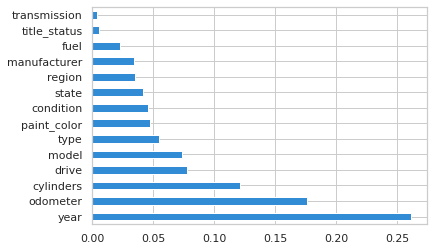

time: 7.28 s


In [0]:
%matplotlib inline
interpreter = Interpretation(x_test2, feature_names=df2.columns)
model = InMemoryModel(clf.predict, examples=x_train2, unique_values=clf.classes_)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending = False, n_jobs = 1)

XGBoost

2020-03-24 17:46:59,320 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-03-24 17:46:59,398 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[14/14] features ████████████████████ Time elapsed: 12 seconds

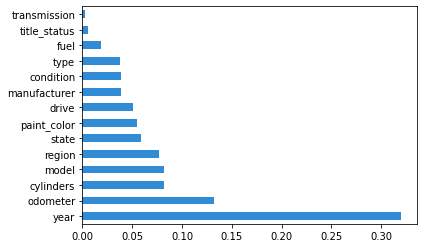

time: 19.8 s


In [0]:
%matplotlib inline
interpreter = Interpretation(x_test2, feature_names=df2.columns)
model = InMemoryModel(xgb.predict, examples=x_train2, unique_values=xgb.classes_)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending = False, n_jobs = 1)

Neural Network

2020-03-24 17:54:24,646 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-03-24 17:54:24,724 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[14/14] features ████████████████████ Time elapsed: 3 seconds

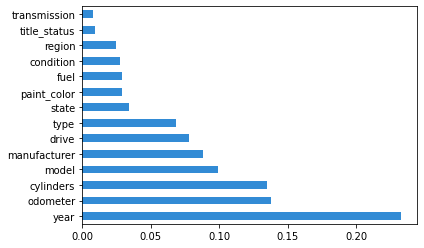

time: 5.01 s


In [0]:
%matplotlib inline
interpreter = Interpretation(x_test2, feature_names=df2.columns)
model = InMemoryModel(nn.predict, examples=x_train2, unique_values=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
plots = interpreter.feature_importance.plot_feature_importance(model, ascending = False, n_jobs = 1)

# Classificazione prezzo 70 modelli (valutata su RMSE)

In [0]:
df = pd.read_csv('/content/drive/My Drive/progetto_bdie/CONSEGNA/clean_rmse.csv', index_col=0)

time: 128 ms


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140503 entries, 15 to 539758
Data columns (total 15 columns):
region          140503 non-null int64
price           140503 non-null int64
year            140503 non-null int64
manufacturer    140503 non-null int64
model           140503 non-null int64
condition       140503 non-null int64
cylinders       140503 non-null int64
fuel            140503 non-null int64
odometer        140503 non-null int64
title_status    140503 non-null int64
transmission    140503 non-null int64
drive           140503 non-null int64
type            140503 non-null int64
paint_color     140503 non-null int64
state           140503 non-null int64
dtypes: int64(15)
memory usage: 17.2 MB
time: 8.95 ms


# Preprocessing per i modelli di classificazione e Train-Test Split

In [0]:
label = df.price
df.drop('price', inplace=True, axis=1)

time: 8.36 ms


In [0]:
df = (df - df.min()) / (df.max() - df.min())
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
15,0.199501,0.864407,0.933333,0.136364,0.000000,0.428571,0.5,1.0,0.0,0.0,0.5,0.750000,0.000000,0.10
43,0.807980,0.694915,0.600000,0.560606,0.166667,0.714286,0.5,1.0,0.0,0.0,0.0,0.000000,0.083333,0.62
58,0.324190,0.474576,0.133333,0.803030,0.333333,0.857143,0.5,1.0,0.0,0.0,0.0,0.833333,0.000000,0.54
86,0.807980,0.949153,0.800000,0.000000,0.000000,0.857143,0.5,1.0,0.0,0.0,0.0,0.833333,0.000000,0.62
91,0.698254,0.677966,0.800000,0.045455,0.500000,0.714286,0.0,1.0,0.0,0.0,0.0,0.833333,0.916667,0.28


time: 88.4 ms


In [0]:
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

time: 26.4 ms


# Classificatori

## Random Forest

In [0]:
clf = RandomForestRegressor(n_estimators=100, max_depth=24, random_state=42)
clf.fit(x_train, y_train)
rf_pred = clf.predict(x_test)

time: 1min 35s


In [0]:
print('RMSE RandomForest: ', np.sqrt(mean_squared_error(y_test, rf_pred)))

RMSE RandomForest:  2924.054800847119
time: 2.86 ms


## XGBoost

In [0]:
xgb = XGBRegressor(max_depth=30, learning_rate=0.1, n_estimators=50, gamma= 0,
                    objective='reg:squarederror', subsample=0.6, colsample_bytree=0.6, seed=42)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


time: 29.3 s


In [0]:
print('RMSE XGBoost: ', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE XGBoost:  2912.5938340808575
time: 2.39 ms


## Neural Network

In [0]:
n_classes = len(np.unique(y_train))
n_features = x_train.shape[1]

time: 6.73 ms


In [0]:
model = Sequential()

model.add(Dense(n_features, input_dim =  n_features, activation = "relu"))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear", kernel_initializer='normal'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              15360     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)              

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
mc = ModelCheckpoint("/content/drive/My Drive/progetto_bdie/ModelCheckpoint/nn_semplice2.hdf5", monitor='val_loss', verbose=0, save_best_only=True)

model.compile(keras.optimizers.adam(), 
              loss='mean_squared_error',
              metrics=["mean_squared_error"])

time: 35.4 ms


In [0]:
history = model.fit(x_train, y_train, 
                    batch_size = 512,
                    epochs = 300, 
                    validation_split = 0.2,
                    callbacks = [es, mc])

Train on 89921 samples, validate on 22481 samples
Epoch 1/300
89921/89921 [==============================] - 3s 33us/step - loss: 97101235.0312 - mean_squared_error: 97101235.0312 - val_loss: 37831687.8906 - val_mean_squared_error: 37831687.8906
Epoch 2/300
89921/89921 [==============================] - 2s 23us/step - loss: 34383693.3965 - mean_squared_error: 34383693.3965 - val_loss: 32406137.5846 - val_mean_squared_error: 32406137.5846
Epoch 3/300
89921/89921 [==============================] - 2s 23us/step - loss: 29779154.6368 - mean_squared_error: 29779154.6368 - val_loss: 27046210.3801 - val_mean_squared_error: 27046210.3801
Epoch 4/300
89921/89921 [==============================] - 2s 23us/step - loss: 25347743.9465 - mean_squared_error: 25347743.9465 - val_loss: 23566761.8088 - val_mean_squared_error: 23566761.8088
Epoch 5/300
89921/89921 [==============================] - 2s 23us/step - loss: 22928923.1405 - mean_squared_error: 22928923.1405 - val_loss: 21078001.4699 - val_mean

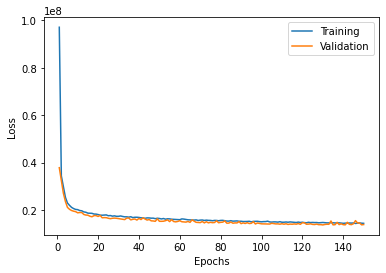

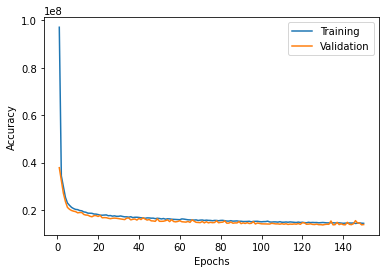

time: 375 ms


In [0]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['mean_squared_error'])
    plt.plot(x_plot, network_history.history['val_mean_squared_error'])
    plt.legend(['Training', 'Validation'])
    
plot_history(history)

In [0]:
model = load_model("/content/drive/My Drive/progetto_bdie/ModelCheckpoint/nn_semplice2.hdf5")

time: 2.41 s


In [0]:
y_pred = model.predict(x_test.values)

time: 1.51 s


In [0]:
print('RMSE NN: ', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE NN:  3516.081396549808
time: 3.64 ms
